Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.util
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime
import rasterio as rio
from scipy import interpolate

In [2]:
run ../util/setupConsole_su

In [3]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirERA5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirProj = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirCPC = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Data-edcoffel-F20/CPC/tmax'
dirGLDAS = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Data-edcoffel-F20/GLDAS/noah-2-10'

In [4]:
# files = glob.glob('%s/monthly/transpiration_new_monthly_*.nc'%dirERA5Land)
# for f in files:
#     os.rename(f,'%s/monthly/transpiration_%s.nc'%(dirERA5Land,f[-7:-3])) 

In [5]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [6]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [7]:
region = 'global'
crop = 'Maize'

if region == 'global':
    latRange = [-90, 90]
    lonRange = [0, 360]
elif region == 'us':
    latRange = [20, 57]
    lonRange = [220, 300]
elif region == 'china':
    latRange = [25, 45]
    lonRange = [105, 123]
elif region == 'eu':
    latRange = [38, 56]
    lonRange = [-5, 40]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_current = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})


if region == 'global':
    regridMesh = regridMesh_global
else:
    regridMesh = regridMesh_current

In [8]:
rebuild = False
if rebuild:
    crop_pasterland_dir = '%s/CroplandPastureArea2000_Geotiff/CroplandPastureArea2000_Geotiff'%dirAgData
    pastureData_tif = rio.open('%s/Pasture2000_5m.tif'%crop_pasterland_dir)
    pastureData = pastureData_tif.read(1)

    cropData_tif = rio.open('%s/Cropland2000_5m.tif'%crop_pasterland_dir)
    cropData = cropData_tif.read(1)

    latOld = np.linspace(pastureData_tif.bounds.bottom, pastureData_tif.bounds.top, pastureData_tif.shape[0])
    lonOld = np.linspace(pastureData_tif.bounds.left, pastureData_tif.bounds.right, pastureData_tif.shape[1])
    lonOld[lonOld<0] += 360

    pastureInterp = interpolate.interp2d(lonOld, latOld, pastureData, kind='linear')
    cropInterp = interpolate.interp2d(lonOld, latOld, cropData, kind='linear')

    latNew = era5_lat#regridMesh['lat']
    lonNew = era5_lon#np.roll(regridMesh['lon'], int(regridMesh['lon'].size/2))

    pastureRegrid = pastureInterp(lonNew, latNew)
    pastureRegrid[pastureRegrid < 0] = np.nan
#     pastureRegrid = np.flipud(pastureRegrid)
    # pastureRegrid = np.roll(pastureRegrid, int(pastureRegrid.shape[1]/2), axis=1)

    cropRegrid = cropInterp(lonNew, latNew)
    cropRegrid[cropRegrid < 0] = np.nan
#     cropRegrid = np.flipud(cropRegrid)
    # cropRegrid = np.roll(cropRegrid, int(cropRegrid.shape[1]/2), axis=1)

    with open('cropped_area/crop_land_regrid_era5.dat', 'wb') as f:
        pickle.dump(cropRegrid, f)
    with open('cropped_area/pasture_land_regrid_era5.dat', 'wb') as f:
        pickle.dump(pastureRegrid, f)
else:
    with open('cropped_area/crop_land_regrid_era5.dat', 'rb') as f:
        cropRegrid = pickle.load(f)
    with open('cropped_area/pasture_land_regrid_era5.dat', 'rb') as f:
        pastureRegrid = pickle.load(f)

In [9]:
rebuild = False

model = 'access-esm1-5'
rcp = 'historical'
members = [x.split('/')[-2] for x in glob.glob("%s/%s/*/"%(dirCmip6, model))]

if rebuild:
    for member in members:
        print('loading %s for %s'%(member, model))

        if not os.path.isfile('cmip6_output/growing_season/cmip6_Maize_grow_%s_%s_tasmax_max_global_%s.nc'%(rcp, member, model)):
            print('skipping %s, base file DOESNT EXIST'%model)
            continue

        ds_global_tmax = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_%s_%s_tasmax_max_global_%s.nc'%(rcp, member, model))

        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_tmax.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_tmax.tasmax_grow_max)

        da_global_tasmax_grow_tmax_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_tmax.time, 'lat':ds_global_tmax.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })

        ds_global_tasmax_grow_tmax_cyc = xr.Dataset()
        ds_global_tasmax_grow_tmax_cyc['tasmax_grow_max'] = da_global_tasmax_grow_tmax_cyc

        regridder = xe.Regridder(ds_global_tasmax_grow_tmax_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_tasmax_grow_tmax_cyc_regrid = regridder(ds_global_tasmax_grow_tmax_cyc)

        ds_global_tasmax_grow_tmax_cyc_regrid = ds_global_tasmax_grow_tmax_cyc_regrid.assign_coords({'model':model})
        ds_global_tasmax_grow_tmax_cyc_regrid = ds_global_tasmax_grow_tmax_cyc_regrid.assign_coords({'member':member})

        ds_global_tasmax_grow_tmax_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_%s_regrid.nc'%(crop, region, model, member))


In [10]:

rebuild_temp = False
rebuild_pr = False
rebuild_pr_water_year = False
rebuild_tran = False
rebuild_lai = False
rebuild_evspsblveg = False
rebuild_evspsblsoi = False
rebuild_cropFrac = False

for m, model in enumerate(cmip6_models):

    if rebuild_temp:
        print('loading temp %s'%model)

#         if os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model)):
#             print('skipping %s, exists'%cmip6_models[m])
#             continue

        if not os.path.isfile('cmip6_output/growing_season/cmip6_Maize_grow_historical_r1i1p1f1_tasmax_max_global_%s_fixed_sh.nc'%model):
            print('skipping %s, base file DOESNT EXIST'%model)
            continue

        ds_global_tmax = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_historical_r1i1p1f1_tasmax_max_global_%s_fixed_sh.nc'%model)
        ds_global_tmean = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_historical_r1i1p1f1_tasmax_mean_global_%s_fixed_sh.nc'%model)

        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_tmax.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_tmax.tasmax_grow_max)

        da_global_tasmax_grow_tmax_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_tmax.time, 'lat':ds_global_tmax.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })

        ds_global_tasmax_grow_tmax_cyc = xr.Dataset()
        ds_global_tasmax_grow_tmax_cyc['tasmax_grow_max'] = da_global_tasmax_grow_tmax_cyc

        regridder = xe.Regridder(ds_global_tasmax_grow_tmax_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_tasmax_grow_tmax_cyc_regrid = regridder(ds_global_tasmax_grow_tmax_cyc)



        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_tmean.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_tmean.tasmax_grow_mean)

        da_global_tasmax_grow_tmean_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_tmean.time, 'lat':ds_global_tmean.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })

        ds_global_tasmax_grow_tmean_cyc = xr.Dataset()
        ds_global_tasmax_grow_tmean_cyc['tasmax_grow_mean'] = da_global_tasmax_grow_tmean_cyc

        regridder = xe.Regridder(ds_global_tasmax_grow_tmean_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_tasmax_grow_tmean_cyc_regrid = regridder(ds_global_tasmax_grow_tmean_cyc)

        ds_global_tasmax_grow_tmax_cyc_regrid = ds_global_tasmax_grow_tmax_cyc_regrid.assign_coords({'model':model})
        ds_global_tasmax_grow_tmean_cyc_regrid = ds_global_tasmax_grow_tmean_cyc_regrid.assign_coords({'model':model})

        ds_global_tasmax_grow_tmax_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid_fixed_sh.nc'%(crop, region, model))
        ds_global_tasmax_grow_tmean_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_tasmax_grow_mean_%s_%s_regrid_fixed_sh.nc'%(crop, region, model))

                    
    # CROP FRAC
    if rebuild_cropFrac:
        if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_fixed_sh.nc'%(crop, model)):
            print('loading cropFrac for %s'%model)
            ds_global_cropFrac = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_fixed_sh.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_cropFrac.lon)
            cropFrac_data = cartopy.util.add_cyclic_point(ds_global_cropFrac.grow_cropFrac)

            da_global_cropFrac_grow_cyc = xr.DataArray(data   = cropFrac_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_cropFrac.time, 'lat':ds_global_cropFrac.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_cropFrac_grow_cyc = xr.Dataset()
            ds_global_cropFrac_grow_cyc['grow_cropFrac'] = da_global_cropFrac_grow_cyc

            regridder = xe.Regridder(ds_global_cropFrac_grow_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_cropFrac_grow_cyc_regrid = regridder(ds_global_cropFrac_grow_cyc)

            ds_global_cropFrac_grow_cyc_regrid = ds_global_cropFrac_grow_cyc_regrid.assign_coords({'model':model})
            ds_global_cropFrac_grow_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))

        else:
            print('skipping cropFrac %s, doesn\'t exists'%cmip6_models[m])




    # PRECIP
    if rebuild_pr:
        if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_historical_pr_mean_global_%s_fixed_sh.nc'%(crop, model)):
            print('loading pr for %s'%model)
            ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_historical_pr_mean_global_%s_fixed_sh.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_pr.lon)
            pr_data = cartopy.util.add_cyclic_point(ds_global_pr.pr_grow_mean)

            da_global_grow_pr_cyc = xr.DataArray(data   = pr_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_pr.time, 'lat':ds_global_pr.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_grow_pr_cyc = xr.Dataset()
            ds_global_grow_pr_cyc['pr_grow_mean'] = da_global_grow_pr_cyc

            regridder = xe.Regridder(da_global_grow_pr_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_grow_pr_cyc_regrid = regridder(ds_global_grow_pr_cyc)

            ds_global_grow_pr_cyc_regrid = ds_global_grow_pr_cyc_regrid.assign_coords({'model':model})
            ds_global_grow_pr_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid_fixed_sh.nc'%(crop, model))

        else:
            print('skipping pr %s, doesn\'t exists'%cmip6_models[m])
            
            
    # WATER YEAR PRECIP
    if rebuild_pr_water_year:
        if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_historical_pr_mean_global_water_year_%s.nc'%(crop, model)):
            print('loading pr wy for %s'%model)
            ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_historical_pr_mean_global_water_year_%s.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_pr.lon)
            pr_data = cartopy.util.add_cyclic_point(ds_global_pr.pr_grow_mean)

            da_global_grow_pr_cyc = xr.DataArray(data   = pr_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_pr.time, 'lat':ds_global_pr.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_grow_pr_cyc = xr.Dataset()
            ds_global_grow_pr_cyc['pr_grow_mean'] = da_global_grow_pr_cyc

            regridder = xe.Regridder(da_global_grow_pr_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_grow_pr_cyc_regrid = regridder(ds_global_grow_pr_cyc)

            ds_global_grow_pr_cyc_regrid = ds_global_grow_pr_cyc_regrid.assign_coords({'model':model})
            ds_global_grow_pr_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_water_year_%s_regrid.nc'%(crop, model))

        else:
            print('skipping pr wy %s, doesn\'t exists'%cmip6_models[m])
            
            
    # TRAN
    if rebuild_tran:
        if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_fixed_sh.nc'%(crop, model)):
            print('loading tran for %s'%model)
            ds_global_tran = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_fixed_sh.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_tran.lon)
            tran_data = cartopy.util.add_cyclic_point(ds_global_tran.grow_tran)

            da_global_grow_tran_cyc = xr.DataArray(data   = tran_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_tran.time, 'lat':ds_global_tran.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_grow_tran_cyc = xr.Dataset()
            ds_global_grow_tran_cyc['tran_grow_mean'] = da_global_grow_tran_cyc

            regridder = xe.Regridder(da_global_grow_tran_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_grow_tran_cyc_regrid = regridder(ds_global_grow_tran_cyc)

            ds_global_grow_tran_cyc_regrid = ds_global_grow_tran_cyc_regrid.assign_coords({'model':model})
            ds_global_grow_tran_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))

        else:
            print('skipping tran %s, doesn\'t exists'%cmip6_models[m])
        
        
    # EVAP FROM CANOPY
    if rebuild_evspsblveg:
        if os.path.isfile('cmip6_output/growing_season/cmip6_evspsblveg_grow_%s_mon_global_%s_fixed_sh.nc'%(crop, model)):
            print('loading evspsblveg for %s'%model)
            ds_global_evspsblveg = xr.open_dataset('cmip6_output/growing_season/cmip6_evspsblveg_grow_%s_mon_global_%s_fixed_sh.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_evspsblveg.lon)
            evspsblveg_data = cartopy.util.add_cyclic_point(ds_global_evspsblveg.grow_evap)

            da_global_grow_evspsblveg_cyc = xr.DataArray(data   = evspsblveg_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_evspsblveg.time, 'lat':ds_global_evspsblveg.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_grow_evspsblveg_cyc = xr.Dataset()
            ds_global_grow_evspsblveg_cyc['evspsblveg_grow_mean'] = da_global_grow_evspsblveg_cyc

            regridder = xe.Regridder(da_global_grow_evspsblveg_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_grow_evspsblveg_cyc_regrid = regridder(ds_global_grow_evspsblveg_cyc)

            ds_global_grow_evspsblveg_cyc_regrid = ds_global_grow_evspsblveg_cyc_regrid.assign_coords({'model':model})
            ds_global_grow_evspsblveg_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))

        else:
            print('skipping evspsblveg %s, doesn\'t exists'%cmip6_models[m])
        
        
    # EVAP FROM SOIL
    if rebuild_evspsblsoi:
        if os.path.isfile('cmip6_output/growing_season/cmip6_evspsblsoi_grow_%s_mon_global_%s_fixed_sh.nc'%(crop, model)):
            print('loading evspsblsoi for %s'%model)
            ds_global_evspsblsoi = xr.open_dataset('cmip6_output/growing_season/cmip6_evspsblsoi_grow_%s_mon_global_%s_fixed_sh.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_evspsblsoi.lon)
            evspsblsoi_data = cartopy.util.add_cyclic_point(ds_global_evspsblsoi.grow_evap)

            da_global_grow_evspsblsoi_cyc = xr.DataArray(data   = evspsblsoi_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_evspsblsoi.time, 'lat':ds_global_evspsblsoi.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'mm'
                                })

            ds_global_grow_evspsblsoi_cyc = xr.Dataset()
            ds_global_grow_evspsblsoi_cyc['evspsblsoi_grow_mean'] = da_global_grow_evspsblsoi_cyc

            regridder = xe.Regridder(da_global_grow_evspsblsoi_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_grow_evspsblsoi_cyc_regrid = regridder(ds_global_grow_evspsblsoi_cyc)

            ds_global_grow_evspsblsoi_cyc_regrid = ds_global_grow_evspsblsoi_cyc_regrid.assign_coords({'model':model})
            ds_global_grow_evspsblsoi_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))

        else:
            print('skipping evspsblsoi %s, doesn\'t exists'%cmip6_models[m])
            
            
            
            
            
    # LAI
    if rebuild_lai:
        if os.path.isfile('cmip6_output/growing_season/cmip6_lai_grow_%s_mon_global_%s_fixed_sh.nc'%(crop, model)):
            print('loading lai for %s'%model)
            ds_global_lai = xr.open_dataset('cmip6_output/growing_season/cmip6_lai_grow_%s_mon_global_%s_fixed_sh.nc'%(crop, model))

            # add cyclic point before regridding
            lon_data = cartopy.util.add_cyclic_point(ds_global_lai.lon)
            lai_data = cartopy.util.add_cyclic_point(ds_global_lai.grow_lai)

            da_global_grow_lai_cyc = xr.DataArray(data   = lai_data, 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':ds_global_lai.time, 'lat':ds_global_lai.lat, 'lon':lon_data},
                              attrs  = {'units'     : 'LAI'
                                })

            ds_global_grow_lai_cyc = xr.Dataset()
            ds_global_grow_lai_cyc['lai_grow_mean'] = da_global_grow_lai_cyc

            regridder = xe.Regridder(da_global_grow_lai_cyc, regridMesh, 'bilinear', reuse_weights=True)
            regridder.clean_weight_file()
            ds_global_grow_lai_cyc_regrid = regridder(ds_global_grow_lai_cyc)

            ds_global_grow_lai_cyc_regrid = ds_global_grow_lai_cyc_regrid.assign_coords({'model':model})
            ds_global_grow_lai_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_lai_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))

        else:
            print('skipping lai %s, doesn\'t exists'%cmip6_models[m])
        
        



In [11]:
# calc t/et

recalc = False

if recalc:
    for model in cmip6_models:

        if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)) and \
            os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)) and \
            os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)):

            print('calc t/et for %s'%model)

            evap_canopy = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))
            evap_soil = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))
            trans = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))

            et = trans.tran_grow_mean + evap_canopy.evspsblveg_grow_mean + evap_soil.evspsblsoi_grow_mean
            t = trans.tran_grow_mean

            t_et = t/et

            da_t_et = xr.DataArray(data   = t_et, 
                                  dims   = ['time', 'lat', 'lon'],
                                  coords = {'time':t.time, 'lat':t.lat, 'lon':t.lon},
                                  attrs  = {'units'     : 'Fraction'
                                    })
            ds_t_et = xr.Dataset()
            ds_t_et['t_et_grow_mean'] = da_t_et
            ds_t_et = ds_t_et.assign_coords({'model':model})

            ds_t_et.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_t_et_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))


In [14]:
# calc t/p

recalc = True

if recalc:
    for model in cmip6_models:

        if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid_fixed_sh.nc'%(crop, model)) and \
           os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_water_year_%s_regrid.nc'%(crop, model)):

            print('calc t/p for %s'%model)

            trans = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))
            precip = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_water_year_%s_regrid.nc'%(crop, model))

            t = trans.tran_grow_mean
            
            pr = precip.pr_grow_mean
            t_pr = t/pr

            da_t_pr = xr.DataArray(data   = t_pr, 
                                  dims   = ['time', 'lat', 'lon'],
                                  coords = {'time':t.time, 'lat':t.lat, 'lon':t.lon},
                                  attrs  = {'units'     : 'Fraction'
                                    })
            ds_t_pr = xr.Dataset()
            ds_t_pr['t_pr_grow_mean'] = da_t_pr
            ds_t_pr = ds_t_pr.assign_coords({'model':model})

            ds_t_pr.to_netcdf('cmip6_output/growing_season/cmip6_%s_grow_t_pr_mon_global_%s_regrid_fixed_sh.nc'%(crop, model))


calc t/p for bcc-esm1
calc t/p for canesm5
calc t/p for gfdl-esm4
calc t/p for kace-1-0-g
calc t/p for fgoals-g3
calc t/p for ipsl-cm6a-lr
calc t/p for miroc6
calc t/p for mri-esm2-0
calc t/p for noresm2-lm


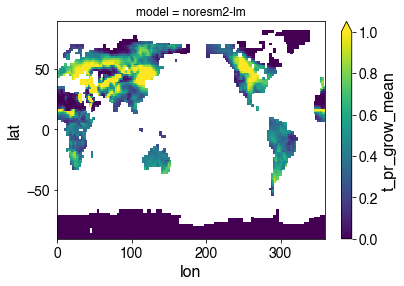

In [21]:
ds_t_pr.t_pr_grow_mean.mean(dim='time').plot(vmin=0,vmax=1)

In [17]:
# GLDAS DATA


rebuild = False

gldas_model = 'NOAH'

if gldas_model == 'NOAH':
    tran_var = 'Tveg_tavg'
else:
    tran_var = 'TVeg_tavg'

if rebuild:

    gldas_tran_grow_mean = xr.Dataset()
    gldas_soil_evap_grow_mean = xr.Dataset()
    gldas_canopy_evap_grow_mean = xr.Dataset()
    gldas_et_grow_mean = xr.Dataset()
    
    for y, year in enumerate(range(1981, 2014+1)):

        print('loading gldas growing season for %d'%year)

        ds_global_tran = xr.open_dataset('gldas_output/gldas-%s_%s_%s_%s_grow_mean_global_%s_fixed_sh.nc'%(gldas_model, tran_var, crop, tran_var, year))
        ds_global_soil_evap = xr.open_dataset('gldas_output/gldas-%s_ESoil_tavg_%s_ESoil_tavg_grow_mean_global_%s_fixed_sh.nc'%(gldas_model, crop, year))
        ds_global_canopy_evap = xr.open_dataset('gldas_output/gldas-%s_ECanop_tavg_%s_ECanop_tavg_grow_mean_global_%s_fixed_sh.nc'%(gldas_model, crop, year))
        ds_global_et = xr.open_dataset('gldas_output/gldas-%s_Evap_tavg_%s_Evap_tavg_grow_mean_global_%s_fixed_sh.nc'%(gldas_model, crop, year))
        
        if y == 0:
            gldas_tran_grow_mean = ds_global_tran
            gldas_soil_evap_grow_mean = ds_global_soil_evap
            gldas_canopy_evap_grow_mean = ds_global_canopy_evap
            gldas_et_grow_mean = ds_global_et

        else:
            gldas_tran_grow_mean = xr.concat([gldas_tran_grow_mean, ds_global_tran], dim='time')
            gldas_soil_evap_grow_mean = xr.concat([gldas_soil_evap_grow_mean, ds_global_soil_evap], dim='time')
            gldas_canopy_evap_grow_mean = xr.concat([gldas_canopy_evap_grow_mean, ds_global_canopy_evap], dim='time')
            gldas_et_grow_mean = xr.concat([gldas_et_grow_mean, ds_global_et], dim='time')
            

    gldas_tran_grow_mean = gldas_tran_grow_mean.assign_coords({'time':np.arange(1981, 2015)})
    gldas_soil_evap_grow_mean = gldas_soil_evap_grow_mean.assign_coords({'time':np.arange(1981, 2015)})
    gldas_canopy_evap_grow_mean = gldas_canopy_evap_grow_mean.assign_coords({'time':np.arange(1981, 2015)})
    gldas_et_grow_mean = gldas_et_grow_mean.assign_coords({'time':np.arange(1981, 2015)})
    
    if rebuild:
        regridder = xe.Regridder(gldas_tran_grow_mean, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        gldas_tran_grow_mean_regrid = regridder(gldas_tran_grow_mean)
        gldas_tran_grow_mean_regrid.to_netcdf('gldas_output/gldas_%s_%s_tran_grow_mean_regrid_%s_fixed_sh.nc'%(gldas_model,crop,region))
        
        regridder = xe.Regridder(gldas_soil_evap_grow_mean, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        gldas_soil_evap_grow_mean_regrid = regridder(gldas_soil_evap_grow_mean)
        gldas_soil_evap_grow_mean_regrid.to_netcdf('gldas_output/gldas_%s_%s_soil_evap_grow_mean_regrid_%s_fixed_sh.nc'%(gldas_model, crop,region))
        
        regridder = xe.Regridder(gldas_canopy_evap_grow_mean, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        gldas_canopy_evap_grow_mean_regrid = regridder(gldas_canopy_evap_grow_mean)
        gldas_canopy_evap_grow_mean_regrid.to_netcdf('gldas_output/gldas_%s_%s_canopy_evap_grow_mean_regrid_%s_fixed_sh.nc'%(gldas_model,crop,region))
        
        regridder = xe.Regridder(gldas_et_grow_mean, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        gldas_et_grow_mean_regrid = regridder(gldas_et_grow_mean)
        gldas_et_grow_mean_regrid.to_netcdf('gldas_output/gldas_%s_%s_et_grow_mean_regrid_%s_fixed_sh.nc'%(gldas_model,crop,region))

else:
    gldas_tran_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_tran_grow_mean_regrid_%s_fixed_sh.nc'%(gldas_model,crop,region))
    gldas_soil_evap_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_soil_evap_grow_mean_regrid_%s_fixed_sh.nc'%(gldas_model, crop,region))
    gldas_canopy_evap_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_canopy_evap_grow_mean_regrid_%s_fixed_sh.nc'%(gldas_model,crop,region))
    gldas_et_grow_mean_regrid = xr.open_dataset('gldas_output/gldas_%s_%s_et_grow_mean_regrid_%s_fixed_sh.nc'%(gldas_model,crop,region))
    



In [13]:
# FUTURE DATA

rebuild_temp = False
rebuild_pr = False
rebuild_ef = False

for m, model in enumerate(cmip6_models):

    if rebuild_temp:
        print('loading temp %s'%model)

        if not os.path.isfile('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_tasmax_max_global_%s.nc'%model):
            print('skipping %s, base file DOESNT EXIST'%model)
            continue

        ds_global_tmax = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_tasmax_max_global_%s.nc'%model)
        ds_global_tmean = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_tasmax_mean_global_%s.nc'%model)

        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_tmax.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_tmax.tasmax_grow_max)

        da_global_tasmax_grow_tmax_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_tmax.time, 'lat':ds_global_tmax.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })

        ds_global_tasmax_grow_tmax_cyc = xr.Dataset()
        ds_global_tasmax_grow_tmax_cyc['tasmax_grow_max'] = da_global_tasmax_grow_tmax_cyc

        regridder = xe.Regridder(ds_global_tasmax_grow_tmax_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_tasmax_grow_tmax_cyc_regrid = regridder(ds_global_tasmax_grow_tmax_cyc)



        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_tmean.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_tmean.tasmax_grow_mean)

        da_global_tasmax_grow_tmean_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_tmean.time, 'lat':ds_global_tmean.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })

        ds_global_tasmax_grow_tmean_cyc = xr.Dataset()
        ds_global_tasmax_grow_tmean_cyc['tasmax_grow_mean'] = da_global_tasmax_grow_tmean_cyc

        regridder = xe.Regridder(ds_global_tasmax_grow_tmean_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_tasmax_grow_tmean_cyc_regrid = regridder(ds_global_tasmax_grow_tmean_cyc)

        ds_global_tasmax_grow_tmax_cyc_regrid = ds_global_tasmax_grow_tmax_cyc_regrid.assign_coords({'model':model})
        ds_global_tasmax_grow_tmean_cyc_regrid = ds_global_tasmax_grow_tmean_cyc_regrid.assign_coords({'model':model})

        ds_global_tasmax_grow_tmax_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_max_%s_%s_regrid.nc'%(crop, region, model))
        ds_global_tasmax_grow_tmean_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))
        
        
        
        
    if rebuild_pr:
        print('loading pr %s'%model)

        if not os.path.isfile('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_pr_mean_global_%s.nc'%model):
            print('skipping %s, base file DOESNT EXIST'%model)
            continue

        ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_pr_mean_global_%s.nc'%model)

        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_pr.lon)
        pr_data = cartopy.util.add_cyclic_point(ds_global_pr.pr_grow_mean)

        da_global_pr_grow_cyc = xr.DataArray(data   = pr_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_pr.time, 'lat':ds_global_pr.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'mm'
                            })

        ds_global_pr_grow_cyc = xr.Dataset()
        ds_global_pr_grow_cyc['pr_grow_mean'] = da_global_pr_grow_cyc

        regridder = xe.Regridder(ds_global_pr_grow_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_pr_grow_cyc_regrid = regridder(ds_global_pr_grow_cyc)

        ds_global_pr_grow_cyc_regrid = ds_global_pr_grow_cyc_regrid.assign_coords({'model':model})
        ds_global_pr_grow_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_pr_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))
        
        
        
        
    if rebuild_ef:
        print('loading ef %s'%model)

        if not os.path.isfile('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_ef_mon_global_%s.nc'%model):
            print('skipping %s, base file DOESNT EXIST'%model)
            continue

        ds_global_ef = xr.open_dataset('cmip6_output/growing_season/cmip6_Maize_grow_ssp245_ef_mon_global_%s.nc'%model)

        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_ef.lon)
        ef_data = cartopy.util.add_cyclic_point(ds_global_ef.grow_ef)

        da_global_ef_grow_cyc = xr.DataArray(data   = ef_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_ef.time, 'lat':ds_global_ef.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'Fraction'
                            })

        ds_global_ef_grow_cyc = xr.Dataset()
        ds_global_ef_grow_cyc['ef_grow_mean'] = da_global_ef_grow_cyc

        regridder = xe.Regridder(ds_global_ef_grow_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_ef_grow_cyc_regrid = regridder(ds_global_ef_grow_cyc)

        ds_global_ef_grow_cyc_regrid = ds_global_ef_grow_cyc_regrid.assign_coords({'model':model})
        ds_global_ef_grow_cyc_regrid.to_netcdf('cmip6_output/growing_season/cmip6_%s_ef_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))




In [14]:
cmip6_tasmax_grow_max = xr.Dataset()
cmip6_tasmax_grow_mean = xr.Dataset()
cmip6_ef_grow = xr.Dataset()
cmip6_mrso_grow = xr.Dataset()
cmip6_pr_grow = xr.Dataset()
cmip6_tran_grow = xr.Dataset()
cmip6_evspsblveg_grow = xr.Dataset()
cmip6_evspsblsoi_grow = xr.Dataset()
cmip6_cropFrac_grow = xr.Dataset()

ef_m = 0
mrso_m = 0
pr_m = 0
tran_m = 0
evspsblveg_m = 0
evspsblsoi_m = 0
cropFrac_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping tasmax max %s'%model)
        
        continue
    
#     print('loading regridded growing season tasmax for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_mean_%s_%s_regrid.nc'%(crop, region, model))
    
    if m == 0:
        cmip6_tasmax_grow_max = ds_global_txx
        cmip6_tasmax_grow_mean = ds_global_t50p
    else:
        cmip6_tasmax_grow_max = xr.concat([cmip6_tasmax_grow_max, ds_global_txx], dim='model')
        cmip6_tasmax_grow_mean = xr.concat([cmip6_tasmax_grow_mean, ds_global_t50p], dim='model')
    
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_ef = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model))
        
        if ef_m == 0:
            cmip6_ef_grow = ds_global_ef
        else:
            cmip6_ef_grow = xr.concat([cmip6_ef_grow, ds_global_ef], dim='model')
        ef_m += 1
    else:
        print('skipping ef %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_mrso = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model))
        
        if mrso_m == 0:
            cmip6_mrso_grow = ds_global_mrso
        else:
            cmip6_mrso_grow = xr.concat([cmip6_mrso_grow, ds_global_mrso], dim='model')
        mrso_m += 1
    else:
        print('skipping mrso %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model)):
        ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model))
        
        if pr_m == 0:
            cmip6_pr_grow = ds_global_pr
        else:
            cmip6_pr_grow = xr.concat([cmip6_pr_grow, ds_global_pr], dim='model')
        pr_m += 1
    else:
        print('skipping pr %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_tran = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model))
        
        if tran_m == 0:
            cmip6_tran_grow = ds_global_tran
        else:
            cmip6_tran_grow = xr.concat([cmip6_tran_grow, ds_global_tran], dim='model')
        tran_m += 1
    else:
        print('skipping tran %s'%model)
        
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_evspsblveg = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid.nc'%(crop, model))
        
        if evspsblveg_m == 0:
            cmip6_evspsblveg_grow = ds_global_evspsblveg
        else:
            cmip6_evspsblveg_grow = xr.concat([cmip6_evspsblveg_grow, ds_global_evspsblveg], dim='model')
        evspsblveg_m += 1
    else:
        print('skipping evspsblveg %s'%model)
        
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_evspsblsoi = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid.nc'%(crop, model))
        
        if evspsblsoi_m == 0:
            cmip6_evspsblsoi_grow = ds_global_evspsblsoi
        else:
            cmip6_evspsblsoi_grow = xr.concat([cmip6_evspsblsoi_grow, ds_global_evspsblsoi], dim='model')
        evspsblsoi_m += 1
    else:
        print('skipping evspsblsoi %s'%model)
    
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_cropFrac = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model))
        
        if cropFrac_m == 0:
            cmip6_cropFrac_grow = ds_global_cropFrac
        else:
            cmip6_cropFrac_grow = xr.concat([cmip6_cropFrac_grow, ds_global_cropFrac], dim='model')
        cropFrac_m += 1
    else:
        print('skipping cropFrac %s'%model)


skipping tran access-cm2
skipping evspsblveg access-cm2
skipping evspsblsoi access-cm2
skipping tran access-esm1-5
skipping evspsblveg access-esm1-5
skipping mrso awi-cm-1-1-mr
skipping pr awi-cm-1-1-mr
skipping tran awi-cm-1-1-mr
skipping evspsblveg awi-cm-1-1-mr
skipping evspsblsoi awi-cm-1-1-mr
skipping cropFrac awi-cm-1-1-mr
skipping pr bcc-csm2-mr
skipping cropFrac bcc-csm2-mr
skipping cropFrac bcc-esm1
skipping tran ec-earth3
skipping evspsblveg ec-earth3
skipping evspsblsoi ec-earth3
skipping cropFrac ec-earth3
skipping ef gfdl-cm4
skipping pr gfdl-cm4
skipping evspsblveg gfdl-cm4
skipping evspsblsoi gfdl-cm4
skipping ef gfdl-esm4
skipping evspsblveg gfdl-esm4
skipping evspsblsoi gfdl-esm4
skipping mrso giss-e2-1-g
skipping pr giss-e2-1-g
skipping evspsblveg giss-e2-1-g
skipping evspsblsoi giss-e2-1-g
skipping cropFrac giss-e2-1-g
skipping ef kace-1-0-g
skipping mrso kace-1-0-g
skipping tran kace-1-0-g
skipping cropFrac kace-1-0-g
skipping evspsblveg fgoals-g3
skipping evspsblso

In [15]:
# LOAD FUTURE DATA

cmip6_tasmax_grow_max_ssp245 = xr.Dataset()
cmip6_pr_grow_ssp245 = xr.Dataset()
cmip6_ef_grow_ssp245 = xr.Dataset()

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_max_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping tasmax max %s'%model)
    else:
        ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_max_%s_%s_regrid.nc'%(crop, region, model))
        ds_global_t50p = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))

        if m == 0:
            cmip6_tasmax_grow_max_ssp245 = ds_global_txx
            cmip6_tasmax_grow_mean_ssp245 = ds_global_t50p
        else:
            cmip6_tasmax_grow_max_ssp245 = xr.concat([cmip6_tasmax_grow_max_ssp245, ds_global_txx], dim='model')
            cmip6_tasmax_grow_mean_ssp245 = xr.concat([cmip6_tasmax_grow_mean_ssp245, ds_global_t50p], dim='model')
            
    
    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_pr_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping pr %s'%model)
    else:
        ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_pr_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))

        if m == 0:
            cmip6_pr_grow_ssp245 = ds_global_pr
        else:
            cmip6_pr_grow_ssp245 = xr.concat([cmip6_pr_grow_ssp245, ds_global_pr], dim='model')
            
            
            
    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_ef_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping ef %s'%model)
    else:
        ds_global_ef = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_ef_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))

        if m == 0:
            cmip6_ef_grow_ssp245 = ds_global_ef
        else:
            cmip6_ef_grow_ssp245 = xr.concat([cmip6_ef_grow_ssp245, ds_global_ef], dim='model')


skipping tasmax max awi-cm-1-1-mr
skipping tasmax max bcc-esm1
skipping pr bcc-esm1
skipping ef bcc-esm1
skipping tasmax max gfdl-cm4
skipping pr gfdl-cm4
skipping ef gfdl-cm4
skipping tasmax max gfdl-esm4
skipping tasmax max giss-e2-1-g
skipping pr giss-e2-1-g
skipping ef giss-e2-1-g
skipping tasmax max kace-1-0-g
skipping tasmax max fgoals-g3
skipping tasmax max inm-cm5-0
skipping ef inm-cm5-0
skipping tasmax max mpi-esm1-2-hr
skipping tasmax max mpi-esm1-2-lr
skipping ef mpi-esm1-2-lr
skipping ef noresm2-lm
skipping tasmax max sam0-unicon
skipping pr sam0-unicon
skipping ef sam0-unicon


In [16]:
# calc temp change between historical cmip6 and ssp245

recalc = False

if recalc:
    for model in cmip6_tasmax_grow_max.model.values:
        print('processing %s...'%model)

        tasmax_grow_max_chg_ssp245 = np.full([cmip6_tasmax_grow_max.lat.values.shape[0], \
                                      cmip6_tasmax_grow_max.lon.values.shape[0]], np.nan)

        pr_grow_chg_ssp245 = np.full([cmip6_pr_grow.lat.values.shape[0], \
                                      cmip6_pr_grow.lon.values.shape[0]], np.nan)

        ef_grow_chg_ssp245 = np.full([cmip6_ef_grow.lat.values.shape[0], \
                                      cmip6_ef_grow.lon.values.shape[0]], np.nan)

        hist_model_ind_temp = np.where((cmip6_tasmax_grow_max.model.values == model))[0]
        fut_model_ind_temp = np.where((cmip6_tasmax_grow_max_ssp245.model.values == model))[0]

        hist_model_ind_pr = np.where((cmip6_pr_grow.model.values == model))[0]
        fut_model_ind_pr = np.where((cmip6_pr_grow_ssp245.model.values == model))[0]

        hist_model_ind_ef = np.where((cmip6_ef_grow.model.values == model))[0]
        fut_model_ind_ef = np.where((cmip6_ef_grow_ssp245.model.values == model))[0]

        for xlat in range(cmip6_tasmax_grow_max.lat.size):
            for ylon in range(cmip6_tasmax_grow_max.lon.size):

                if model in cmip6_tasmax_grow_max_ssp245.model.values:

                    hist_mean = np.nanmean(cmip6_tasmax_grow_max.tasmax_grow_max.values[hist_model_ind_temp, :, xlat, ylon])
                    fut_mean = np.nanmean(cmip6_tasmax_grow_max_ssp245.tasmax_grow_max.values[fut_model_ind_temp, :, xlat, ylon])

                    tasmax_grow_max_chg_ssp245[xlat, ylon] = fut_mean-hist_mean


                if model in cmip6_pr_grow_ssp245.model.values:

                    hist_mean = np.nanmean(cmip6_pr_grow.pr_grow_mean.values[hist_model_ind_pr, :, xlat, ylon])
                    fut_mean = np.nanmean(cmip6_pr_grow_ssp245.pr_grow_mean.values[fut_model_ind_pr, :, xlat, ylon])

                    pr_grow_chg_ssp245[xlat, ylon] = fut_mean-hist_mean



                if model in cmip6_ef_grow_ssp245.model.values:

                    hist_mean = np.nanmean(cmip6_ef_grow.grow_ef.values[hist_model_ind_ef, :, xlat, ylon])
                    fut_mean = np.nanmean(cmip6_ef_grow_ssp245.ef_grow_mean.values[fut_model_ind_ef, :, xlat, ylon])

                    ef_grow_chg_ssp245[xlat, ylon] = fut_mean-hist_mean

        if model in cmip6_tasmax_grow_max_ssp245.model.values:
            with open('cmip6_output/future/cmip6_fut_tx_max_chg_ssp245_%s.dat'%model, 'wb') as f:
                pickle.dump(tasmax_grow_max_chg_ssp245, f)

        if model in cmip6_pr_grow_ssp245.model.values:
            with open('cmip6_output/future/cmip6_fut_pr_chg_ssp245_%s.dat'%model, 'wb') as f:
                pickle.dump(pr_grow_chg_ssp245, f)

        if model in cmip6_ef_grow_ssp245.model.values:
            with open('cmip6_output/future/cmip6_fut_ef_chg_ssp245_%s.dat'%model, 'wb') as f:
                pickle.dump(ef_grow_chg_ssp245, f)

In [17]:
cmip6_tasmax_grow_max_trend = xr.Dataset()
cmip6_tasmax_grow_mean_trend = xr.Dataset()
cmip6_ef_grow_trend = xr.Dataset()
cmip6_pr_grow_trend = xr.Dataset()

ef_m = 0
pr_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_%s_grow_max_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model)):
        print('skipping %s, base file DOESNT EXIST'%model)
        continue
    
    print('loading growing season trends for %s'%model)

    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_trend_global_%s_regrid.nc'%(crop, model)):
        ds_global_ef_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_trend_global_%s_regrid.nc'%(crop, model))
        
        if ef_m == 0:
            cmip6_ef_grow_trend = ds_global_ef_trend
        else:
            cmip6_ef_grow_trend = xr.concat([cmip6_ef_grow_trend, ds_global_ef_trend], dim='model')
        ef_m += 1
    else:
        print('skipping ef %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_trend_global_%s_regrid.nc'%(crop, model)):
        ds_global_pr_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_trend_global_%s_regrid.nc'%(crop, model))
        
        if pr_m == 0:
            cmip6_pr_grow_trend = ds_global_pr_trend
        else:
            cmip6_pr_grow_trend = xr.concat([cmip6_pr_grow_trend, ds_global_pr_trend], dim='model')
        pr_m += 1
    else:
        print('skipping pr %s'%model)
    
    ds_global_txx_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_%s_grow_max_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model))
    ds_global_t50p_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_%s_grow_mean_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model))

    if m == 0:
        cmip6_tasmax_grow_max_trend = ds_global_txx_trend
        cmip6_tasmax_grow_mean_trend = ds_global_t50p_trend
    else:
        cmip6_tasmax_grow_max_trend = xr.concat([cmip6_tasmax_grow_max_trend, ds_global_txx_trend], dim='model')
        cmip6_tasmax_grow_mean_trend = xr.concat([cmip6_tasmax_grow_mean_trend, ds_global_t50p_trend], dim='model')

# cmip6_tasmax_max_trend = cmip6_tasmax_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_monthly_max_trend = cmip6_tasmax_monthly_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_mean_trend = cmip6_tasmax_mean_trend.assign_coords({'model':cmip6_models})


loading growing season trends for access-cm2
loading growing season trends for access-esm1-5
loading growing season trends for awi-cm-1-1-mr
skipping pr awi-cm-1-1-mr
loading growing season trends for bcc-csm2-mr
skipping pr bcc-csm2-mr
loading growing season trends for bcc-esm1
loading growing season trends for canesm5
loading growing season trends for ec-earth3
loading growing season trends for gfdl-cm4
skipping ef gfdl-cm4
skipping pr gfdl-cm4
loading growing season trends for gfdl-esm4
skipping ef gfdl-esm4
loading growing season trends for giss-e2-1-g
skipping pr giss-e2-1-g
loading growing season trends for kace-1-0-g
skipping ef kace-1-0-g
loading growing season trends for fgoals-g3
loading growing season trends for inm-cm5-0
loading growing season trends for ipsl-cm6a-lr
loading growing season trends for miroc6
loading growing season trends for mpi-esm1-2-hr
loading growing season trends for mpi-esm1-2-lr
loading growing season trends for mri-esm2-0
loading growing season trend

In [12]:
# load era5 growing season temps

rebuild_temp = False
rebuild_pr = False
rebuild_pr_water_year = False
rebuild_trans = False
rebuild_evap_from_canopy = False
rebuild_evap_from_soil = False
rebuild_lai = False

rebuild = rebuild_temp or rebuild_pr or rebuild_trans or rebuild_evap_from_canopy or rebuild_evap_from_soil or rebuild_lai or rebuild_pr_water_year

if rebuild or not os.path.isfile('era5/growing_season/era5_%s_tasmax_grow_max_regrid_%s.nc'%(crop,region)):

    era5_tasmax_grow_max = xr.Dataset()
    era5_tasmax_grow_mean = xr.Dataset()

    era5_ef_grow = xr.Dataset()
    era5_pr_grow = xr.Dataset()
    era5_pr_grow_water_year = xr.Dataset()
    era5_trans_grow = xr.Dataset()
    era5_evap_from_canopy_grow = xr.Dataset()
    era5_evap_from_soil_grow = xr.Dataset()
    era5_lai_grow = xr.Dataset()
    
    for y, year in enumerate(range(1981, 2014+1)):

        print('loading era5 growing season for %d'%year)

        if rebuild_temp:
            ds_global_txx = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_max_global_%s_fixed_sh.nc'%(crop, year))
            ds_global_t50p = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_mean_global_%s_fixed_sh.nc'%(crop, year))

        if rebuild_pr:
            ds_global_pr = xr.open_dataset('era5/growing_season/era5_%s_pr_grow_mean_global_%s_fixed_sh.nc'%(crop, year))
            
        if rebuild_pr_water_year:
            ds_global_pr_water_year = xr.open_dataset('era5/growing_season/era5_%s_pr_grow_mean_global_water_year_%s.nc'%(crop, year))
        
        if y == 0:
            if rebuild_temp:
                era5_tasmax_grow_max = ds_global_txx
                era5_tasmax_grow_mean = ds_global_t50p
            
            if rebuild_ef:
                era5_ef_grow = ds_global_ef
                
            if rebuild_pr_water_year:
                era5_pr_grow_water_year = ds_global_pr_water_year
                
            if rebuild_pr:
                era5_pr_grow = ds_global_pr
        else:
            if rebuild_temp:
                era5_tasmax_grow_max = xr.concat([era5_tasmax_grow_max, ds_global_txx], dim='time')
                era5_tasmax_grow_mean = xr.concat([era5_tasmax_grow_mean, ds_global_t50p], dim='time')
            
            if rebuild_ef:
                era5_ef_grow = xr.concat([era5_ef_grow, ds_global_ef], dim='time')
                
            if rebuild_pr:
                era5_pr_grow = xr.concat([era5_pr_grow, ds_global_pr], dim='time')
                
            if rebuild_pr_water_year:
                era5_pr_grow_water_year = xr.concat([era5_pr_grow_water_year, ds_global_pr_water_year], dim='time')

            
        if rebuild_trans:
            if year > 1981:
                ds_global_trans = xr.open_dataset('era5/growing_season/era5_%s_trans_grow_mean_global_%s_fixed_sh.nc'%(crop, year))
            
            # first year for trans
            if year == 1982:
                era5_trans_grow = ds_global_trans
            elif year > 1982:
                era5_trans_grow = xr.concat([era5_trans_grow, ds_global_trans], dim='time')
                
        if rebuild_evap_from_canopy:
            if year > 1981:
                ds_global_evap_from_canopy = xr.open_dataset('era5/growing_season/era5_%s_evap_from_canopy_grow_mean_global_%s_fixed_sh.nc'%(crop, year))
            
            # first year for trans
            if year == 1982:
                era5_evap_from_canopy_grow = ds_global_evap_from_canopy
            elif year > 1982:
                era5_evap_from_canopy_grow = xr.concat([era5_evap_from_canopy_grow, ds_global_evap_from_canopy], dim='time')
                
        if rebuild_evap_from_soil:
            if year > 1981:
                ds_global_evap_from_soil = xr.open_dataset('era5/growing_season/era5_%s_evap_from_soil_grow_mean_global_%s_fixed_sh.nc'%(crop, year))
            
            # first year for trans
            if year == 1982:
                era5_evap_from_soil_grow = ds_global_evap_from_soil
            elif year > 1982:
                era5_evap_from_soil_grow = xr.concat([era5_evap_from_soil_grow, ds_global_evap_from_soil], dim='time')
                
                
        if rebuild_lai:
            if year > 1981:
                ds_global_lai = xr.open_dataset('era5/growing_season/era5_%s_lai_grow_mean_global_%s_fixed_sh.nc'%(crop, year))
            
            # first year for trans
            if year == 1982:
                era5_lai_grow = ds_global_lai
            elif year > 1982:
                era5_lai_grow = xr.concat([era5_lai_grow, ds_global_lai], dim='time')
    
    if rebuild_temp:
        regridder = xe.Regridder(era5_tasmax_grow_max, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_tasmax_grow_max_regrid = regridder(era5_tasmax_grow_max)
        era5_tasmax_grow_max_regrid.to_netcdf('era5/growing_season/era5_%s_tasmax_grow_max_regrid_%s_fixed_sh.nc'%(crop,region))

        regridder = xe.Regridder(era5_tasmax_grow_mean, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_tasmax_grow_mean_regrid = regridder(era5_tasmax_grow_mean)
        era5_tasmax_grow_mean_regrid.to_netcdf('era5/growing_season/era5_%s_tasmax_grow_mean_regrid_%s_fixed_sh.nc'%(crop,region))
    
    if rebuild_ef:
        regridder = xe.Regridder(era5_ef_grow, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_ef_grow_regrid = regridder(era5_ef_grow)
        era5_ef_grow_regrid.to_netcdf('era5/growing_season/era5_%s_ef_grow_regrid_%s.nc'%(crop,region))
    
    if rebuild_pr:
        regridder = xe.Regridder(era5_pr_grow, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_pr_grow_regrid = regridder(era5_pr_grow)*1000
        era5_pr_grow_regrid.to_netcdf('era5/growing_season/era5_%s_pr_grow_regrid_%s_fixed_sh.nc'%(crop,region))
        
    if rebuild_pr_water_year:
        regridder = xe.Regridder(era5_pr_grow_water_year, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_pr_grow_water_year_regrid = regridder(era5_pr_grow_water_year)*1000
        era5_pr_grow_water_year_regrid.to_netcdf('era5/growing_season/era5_%s_pr_grow_water_year_regrid_%s.nc'%(crop,region))
    
    if rebuild_trans:
        regridder = xe.Regridder(era5_trans_grow, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_trans_grow_regrid = regridder(era5_trans_grow)*1000
        era5_trans_grow_regrid.to_netcdf('era5/growing_season/era5_%s_trans_grow_regrid_%s_fixed_sh.nc'%(crop,region))
        
    if rebuild_evap_from_canopy:
        regridder = xe.Regridder(era5_evap_from_canopy_grow, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_evap_from_canopy_grow_regrid = regridder(era5_evap_from_canopy_grow)*1000
        era5_evap_from_canopy_grow_regrid.to_netcdf('era5/growing_season/era5_%s_evap_from_canopy_grow_regrid_%s_fixed_sh.nc'%(crop,region))
        
    if rebuild_evap_from_soil:
        regridder = xe.Regridder(era5_evap_from_soil_grow, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_evap_from_soil_grow_regrid = regridder(era5_evap_from_soil_grow)*1000
        era5_evap_from_soil_grow_regrid.to_netcdf('era5/growing_season/era5_%s_evap_from_soil_grow_regrid_%s_fixed_sh.nc'%(crop,region))
        
    if rebuild_lai:
        regridder = xe.Regridder(era5_lai_grow, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        era5_lai_grow_regrid = regridder(era5_lai_grow)
        era5_lai_grow_regrid.to_netcdf('era5/growing_season/era5_%s_lai_grow_regrid_%s_fixed_sh.nc'%(crop,region))
else:
    era5_tasmax_grow_max_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_max_regrid_%s_fixed_sh.nc'%(crop,region))
    era5_tasmax_grow_mean_regrid = xr.open_dataset('era5/growing_season/era5_%s_tasmax_grow_mean_regrid_%s_fixed_sh.nc'%(crop,region))
    era5_ef_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_ef_grow_regrid_%s.nc'%(crop,region))
    era5_pr_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_pr_grow_regrid_%s_fixed_sh.nc'%(crop,region))
    era5_pr_grow_water_year_regrid = xr.open_dataset('era5/growing_season/era5_%s_pr_grow_water_year_regrid_%s.nc'%(crop,region))
    era5_trans_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_trans_grow_regrid_%s_fixed_sh.nc'%(crop,region))
    era5_evap_from_canopy_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_evap_from_canopy_grow_regrid_%s_fixed_sh.nc'%(crop,region))
    era5_evap_from_soil_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_evap_from_soil_grow_regrid_%s_fixed_sh.nc'%(crop,region))
    era5_lai_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_lai_grow_regrid_%s_fixed_sh.nc'%(crop,region))
    


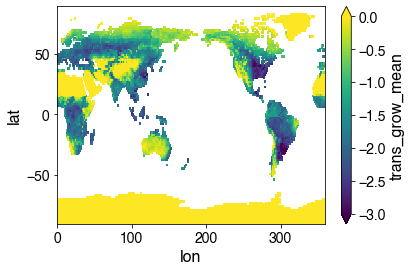

In [13]:
era5_trans_grow_regrid.trans_grow_mean.mean(dim='time').plot(vmin=-3,vmax=0)

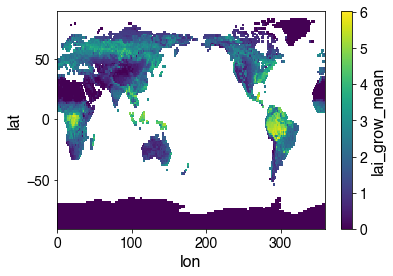

In [14]:
era5_lai_grow_regrid = xr.open_dataset('era5/growing_season/era5_%s_lai_grow_regrid_%s.nc'%(crop,region))
era5_lai_grow_regrid.lai_grow_mean.mean(dim='time').plot()

In [15]:
# REGRID GPCP

recalc = False

if recalc:

    ds_global_gpcp = xr.open_dataset('gpcp_output/gpcp_Maize_grow_mean_global_fixed_sh.nc')

    regridder = xe.Regridder(ds_global_gpcp, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    ds_global_gpcp_regrid = regridder(ds_global_gpcp)
    ds_global_gpcp_regrid.to_netcdf('gpcp_output/gpcp_Maize_grow_mean_global_regrid_fixed_sh.nc')
    
else:
    
    ds_global_gpcp = xr.open_dataset('gpcp_output/gpcp_Maize_grow_mean_global_regrid_fixed_sh.nc')

Create weight file: bilinear_72x144_120x240.nc
Remove file bilinear_72x144_120x240.nc
using dimensions ('lat', 'lon') from data variable precip_grow_mean as the horizontal dimensions for this dataset.


In [22]:
# load CPC growing season temps

rebuild = False

if rebuild or not os.path.isfile('cpc_output/cpc_%s_tasmax_grow_max_regrid_%s_fixed_sh.nc'%(crop,region)):

    cpc_tasmax_grow_max = xr.Dataset()
    
    for y, year in enumerate(range(1981, 2014+1)):

        print('loading cpc growing season for %d'%year)

        ds_global_txx = xr.open_dataset('cpc_output/cpc_%s_grow_max_global_%d_fixed_sh.nc'%(crop, year))
        
        if y == 0:
            cpc_tasmax_grow_max = ds_global_txx

        else:
            cpc_tasmax_grow_max = xr.concat([cpc_tasmax_grow_max, ds_global_txx], dim='time')

    cpc_tasmax_grow_max = cpc_tasmax_grow_max.assign_coords({'time':np.arange(1981, 2015)})
    if rebuild:
        regridder = xe.Regridder(cpc_tasmax_grow_max, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        cpc_tasmax_grow_max_regrid = regridder(cpc_tasmax_grow_max)
        cpc_tasmax_grow_max_regrid.to_netcdf('cpc_output/cpc_%s_tasmax_grow_max_regrid_%s_fixed_sh.nc'%(crop,region))

else:
    cpc_tasmax_grow_max_regrid = xr.open_dataset('cpc_output/cpc_%s_tasmax_grow_max_regrid_%s_fixed_sh.nc'%(crop,region))
    


loading cpc growing season for 1981
loading cpc growing season for 1982
loading cpc growing season for 1983
loading cpc growing season for 1984
loading cpc growing season for 1985
loading cpc growing season for 1986
loading cpc growing season for 1987
loading cpc growing season for 1988
loading cpc growing season for 1989
loading cpc growing season for 1990
loading cpc growing season for 1991
loading cpc growing season for 1992
loading cpc growing season for 1993
loading cpc growing season for 1994
loading cpc growing season for 1995
loading cpc growing season for 1996
loading cpc growing season for 1997
loading cpc growing season for 1998
loading cpc growing season for 1999
loading cpc growing season for 2000
loading cpc growing season for 2001
loading cpc growing season for 2002
loading cpc growing season for 2003
loading cpc growing season for 2004
loading cpc growing season for 2005
loading cpc growing season for 2006
loading cpc growing season for 2007
loading cpc growing season f

In [24]:
# ERA5 T/ET

recalc = False

if recalc:
    et = era5_evap_from_soil_grow_regrid.evap_grow_mean.values + era5_evap_from_canopy_grow_regrid.evap_grow_mean.values + era5_trans_grow_regrid.trans_grow_mean.values
    t = era5_trans_grow_regrid.trans_grow_mean.values
    t_et = t/et

    era5_t_et = xr.Dataset()
    era5_t_et['t_et_grow_mean'] = xr.DataArray(data   = t_et, 
                      dims   = ['time', 'lat', 'lon'],
                      coords = {'time':era5_evap_from_soil_grow_regrid.time, 'lat':era5_evap_from_soil_grow_regrid.lat, 'lon':era5_evap_from_soil_grow_regrid.lon},
                      attrs  = {'units'     : 'Fraction'
                        })
    era5_t_et.to_netcdf('era5/growing_season/era5_t_et_grow_%s_fixed_sh.nc'%region)


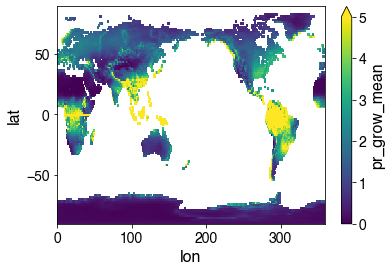

In [25]:
era5_pr_grow_water_year_regrid.pr_grow_mean.mean(dim='time').plot(vmin=0,vmax=5)

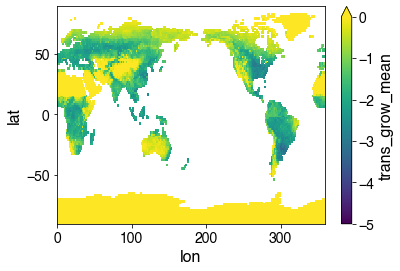

In [26]:
era5_trans_grow_regrid.trans_grow_mean.mean(dim='time').plot(vmin=-5,vmax=0)

In [27]:
# ERA5 T/P

recalc = False

if recalc:
    pr = era5_pr_grow_water_year_regrid.sel(time=slice(1982, 2014)).pr_grow_mean.values
    t = -era5_trans_grow_regrid.trans_grow_mean.values
    t_pr = t/pr

    era5_t_pr = xr.Dataset()
    era5_t_pr['t_pr_grow_mean'] = xr.DataArray(data   = t_pr, 
                      dims   = ['time', 'lat', 'lon'],
                      coords = {'time':era5_trans_grow_regrid.time, 'lat':era5_trans_grow_regrid.lat, 'lon':era5_trans_grow_regrid.lon},
                      attrs  = {'units'     : 'Fraction'
                        })
    era5_t_pr.to_netcdf('era5/growing_season/era5_t_pr_grow_%s_fixed_sh.nc'%region)


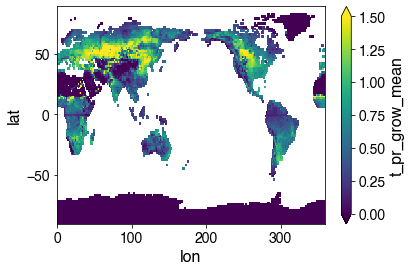

In [28]:
era5_t_pr.t_pr_grow_mean.mean(dim='time').plot(vmin=0,vmax=1.5)

In [18]:
# GLDAS T/ET

recalc = True

if recalc:
    gldas_t_et = gldas_tran_grow_mean_regrid.evap_grow_mean.values / \
                    (gldas_tran_grow_mean_regrid.evap_grow_mean.values + \
                    gldas_soil_evap_grow_mean_regrid.evap_grow_mean.values + \
                    gldas_canopy_evap_grow_mean_regrid.evap_grow_mean.values)

    gldas_t_et_ds = xr.Dataset()
    gldas_t_et_ds['t_et_grow_mean'] = xr.DataArray(data   = gldas_t_et, 
                      dims   = ['time', 'lat', 'lon'],
                      coords = {'time':gldas_tran_grow_mean_regrid.time, 'lat':gldas_tran_grow_mean_regrid.lat, 'lon':gldas_tran_grow_mean_regrid.lon},
                      attrs  = {'units'     : 'Fraction'
                        })
    gldas_t_et_ds.to_netcdf('gldas_output/gldas_t_et_grow_%s_fixed_sh.nc'%region)


In [38]:
# OBS LAI CLIMO

recalc = False

if recalc:
    lai_obs = xr.open_dataset('lai_data/lai_%s_grow_mean_global_fixed_sh.nc'%(crop))

    regridder = xe.Regridder(lai_obs, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    lai_obs_regrid = regridder(lai_obs)
    lai_obs_regrid.to_netcdf('lai_data/lai_%s_grow_mean_regrid_global_fixed_sh.nc'%(crop))
else:
    lai_obs_regrid = xr.open_dataset('lai_data/lai_%s_grow_mean_regrid_global_fixed_sh.nc'%(crop))

Create weight file: bilinear_360x720_120x240.nc
Remove file bilinear_360x720_120x240.nc
using dimensions ('lat', 'lon') from data variable lai_grow_mean as the horizontal dimensions for this dataset.


In [124]:
%%time

recalc = False

# era5 trends for growing season data

if recalc:

    # calc era5 txx and t50p trends
    era5_tasmax_grow_max_trend = xr.Dataset()
    era5_tasmax_grow_mean_trend = xr.Dataset()
    era5_ef_grow_trend = xr.Dataset()
    era5_pr_grow_trend = xr.Dataset()
    era5_trans_grow_trend = xr.Dataset()
    era5_evap_from_canopy_grow_trend = xr.Dataset()
    era5_evap_from_soil_grow_trend = xr.Dataset()

    print('calc era5 txx, t50p, and ef trends')
    tmp_tasmax_grow_max_trend = np.full([era5_tasmax_grow_max_regrid.lat.values.shape[0], era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)
    tmp_tasmax_grow_mean_trend = np.full([era5_tasmax_grow_mean_regrid.lat.values.shape[0], era5_tasmax_grow_mean_regrid.lon.values.shape[0]], np.nan)
    tmp_ef_grow_trend = np.full([era5_ef_grow_regrid.lat.values.shape[0], era5_ef_grow_regrid.lon.values.shape[0]], np.nan)
    tmp_pr_grow_trend = np.full([era5_pr_grow_regrid.lat.values.shape[0], era5_pr_grow_regrid.lon.values.shape[0]], np.nan)
    tmp_trans_grow_trend = np.full([era5_trans_grow_regrid.lat.values.shape[0], era5_trans_grow_regrid.lon.values.shape[0]], np.nan)
    tmp_evap_from_canopy_grow_trend = np.full([era5_evap_from_canopy_grow_regrid.lat.values.shape[0], era5_evap_from_canopy_grow_regrid.lon.values.shape[0]], np.nan)
    tmp_evap_from_soil_grow_trend = np.full([era5_evap_from_soil_grow_regrid.lat.values.shape[0], era5_evap_from_soil_grow_regrid.lon.values.shape[0]], np.nan)

    for xlat in range(tmp_tasmax_grow_max_trend.shape[0]):
        for ylon in range(tmp_tasmax_grow_max_trend.shape[1]):
            cur_tasmax_grow_max = era5_tasmax_grow_max_regrid.tasmax_grow_max.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_tasmax_grow_max, X).fit()
            tmp_tasmax_grow_max_trend[xlat, ylon] = mdl.params[1]*10

            cur_tasmax_grow_mean = era5_tasmax_grow_mean_regrid.tasmax_grow_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_tasmax_grow_mean, X).fit()
            tmp_tasmax_grow_mean_trend[xlat, ylon] = mdl.params[1]*10
            
            cur_ef_grow = era5_ef_grow_regrid.ef_grow.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_ef_grow, X).fit()
            tmp_ef_grow_trend[xlat, ylon] = mdl.params[1]*10
            
            cur_pr_grow = era5_pr_grow_regrid.pr_grow_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_pr_grow, X).fit()
            tmp_pr_grow_trend[xlat, ylon] = mdl.params[1]*10
            
            cur_trans_grow = era5_trans_grow_regrid.trans_grow_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1982, 2014+1))
            mdl = sm.OLS(cur_trans_grow, X).fit()
            tmp_trans_grow_trend[xlat, ylon] = -mdl.params[1]*10
            
            cur_evap_from_canopy_grow = era5_evap_from_canopy_grow_regrid.evap_grow_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1982, 2014+1))
            mdl = sm.OLS(cur_evap_from_canopy_grow, X).fit()
            tmp_evap_from_canopy_grow_trend[xlat, ylon] = -mdl.params[1]*10
            
            cur_evap_from_soil_grow = era5_evap_from_soil_grow_regrid.evap_grow_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1982, 2014+1))
            mdl = sm.OLS(cur_evap_from_soil_grow, X).fit()
            tmp_evap_from_soil_grow_trend[xlat, ylon] = -mdl.params[1]*10
            
            
            

    era5_tasmax_grow_max_trend['tasmax_grow_max_trend'] = xr.DataArray(data   = tmp_tasmax_grow_max_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_tasmax_grow_max_regrid.lat, 'lon':era5_tasmax_grow_max_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_tasmax_grow_max_trend.to_netcdf('era5/growing_season/era5_tasmax_grow_max_trend_%s.nc'%region)

    era5_tasmax_grow_mean_trend['tasmax_grow_mean_trend'] = xr.DataArray(data   = tmp_tasmax_grow_mean_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_tasmax_grow_mean_regrid.lat, 'lon':era5_tasmax_grow_mean_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_tasmax_grow_mean_trend.to_netcdf('era5/growing_season/era5_tasmax_grow_mean_trend_%s.nc'%region)
    
    era5_ef_grow_trend['ef_grow_trend'] = xr.DataArray(data   = tmp_ef_grow_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_ef_grow_regrid.lat, 'lon':era5_ef_grow_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_ef_grow_trend.to_netcdf('era5/growing_season/era5_ef_grow_trend_%s.nc'%region)
    
    era5_pr_grow_trend['pr_grow_trend'] = xr.DataArray(data   = tmp_pr_grow_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_pr_grow_regrid.lat, 'lon':era5_pr_grow_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_pr_grow_trend.to_netcdf('era5/growing_season/era5_pr_grow_trend_%s.nc'%region)
    
    era5_trans_grow_trend['trans_grow_trend'] = xr.DataArray(data   = tmp_trans_grow_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_trans_grow_regrid.lat, 'lon':era5_trans_grow_regrid.lon},
                      attrs  = {'units'     : 'mm/yr/decade'
                        })
    era5_trans_grow_trend.to_netcdf('era5/growing_season/era5_trans_grow_trend_%s.nc'%region)
    
    era5_evap_from_canopy_grow_trend['evap_from_canopy_grow_trend'] = xr.DataArray(data   = tmp_evap_from_canopy_grow_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_evap_from_canopy_grow_regrid.lat, 'lon':era5_evap_from_canopy_grow_regrid.lon},
                      attrs  = {'units'     : 'mm/yr/decade'
                        })
    era5_evap_from_canopy_grow_trend.to_netcdf('era5/growing_season/era5_evap_from_canopy_grow_trend_%s.nc'%region)
    
    era5_evap_from_soil_grow_trend['evap_from_soil_grow_trend'] = xr.DataArray(data   = tmp_evap_from_soil_grow_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_evap_from_soil_grow_regrid.lat, 'lon':era5_evap_from_soil_grow_regrid.lon},
                      attrs  = {'units'     : 'mm/yr/decade'
                        })
    era5_evap_from_soil_grow_trend.to_netcdf('era5/growing_season/era5_evap_from_soil_grow_trend_%s.nc'%region)
else:
    era5_tasmax_grow_max_trend = xr.open_dataset('era5/growing_season/era5_tasmax_grow_max_trend_%s.nc'%region)
    era5_tasmax_grow_mean_trend = xr.open_dataset('era5/growing_season/era5_tasmax_grow_mean_trend_%s.nc'%region)    
    era5_ef_grow_trend = xr.open_dataset('era5/growing_season/era5_ef_grow_trend_%s.nc'%region)
    era5_pr_grow_trend = xr.open_dataset('era5/growing_season/era5_pr_grow_trend_%s.nc'%region)
    era5_trans_grow_trend = xr.open_dataset('era5/growing_season/era5_trans_grow_trend_%s.nc'%region)
    era5_evap_from_canopy_grow_trend = xr.open_dataset('era5/growing_season/era5_evap_from_canopy_grow_trend_%s.nc'%region)
    era5_evap_from_soil_grow_trend = xr.open_dataset('era5/growing_season/era5_evap_from_soil_grow_trend_%s.nc'%region)




CPU times: user 147 ms, sys: 16.1 ms, total: 163 ms
Wall time: 618 ms


In [125]:

# calculate trend bias between cmip6 and era5

recalc = False

if recalc:



    # TASMAX GROWING SEASON MAX
    print('tasmax growing season max')
    cmip6_era5_tasmax_grow_max_trend_bias_sig = np.full(era5_tasmax_grow_max_trend.tasmax_grow_max_trend.shape, np.nan)
    cmip6_era5_tasmax_grow_max_trend_bias = np.full([cmip6_tasmax_grow_max_trend.model.size, era5_tasmax_grow_max_trend.tasmax_grow_max_trend.shape[0], era5_tasmax_grow_max_trend.tasmax_grow_max_trend.shape[1]], np.nan)

    for m, model in enumerate(cmip6_tasmax_grow_max_trend.model):
        cmip6_era5_tasmax_grow_max_trend_bias[m,:,:] = cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.values[m,:,:] - era5_tasmax_grow_max_trend.tasmax_grow_max_trend.values

    for xlat in range(cmip6_era5_tasmax_grow_max_trend_bias_sig.shape[0]):
        for ylon in range(cmip6_era5_tasmax_grow_max_trend_bias_sig.shape[1]):
            t, p = scipy.stats.ttest_1samp(cmip6_era5_tasmax_grow_max_trend_bias[:, xlat, ylon], 0)
            cmip6_era5_tasmax_grow_max_trend_bias_sig[xlat, ylon] = p

    # TASMAX GROWING SEASON MEAN
    print('tasmax growing season mean')
    cmip6_era5_tasmax_grow_mean_trend_bias_sig = np.full(era5_tasmax_grow_mean_trend.tasmax_grow_mean_trend.shape, np.nan)
    cmip6_era5_tasmax_grow_mean_trend_bias = np.full([cmip6_tasmax_grow_max_trend.model.size, era5_tasmax_grow_mean_trend.tasmax_grow_mean_trend.shape[0], era5_tasmax_grow_mean_trend.tasmax_grow_mean_trend.shape[1]], np.nan)

    for m, model in enumerate(cmip6_tasmax_grow_max_trend.model):
        cmip6_era5_tasmax_grow_mean_trend_bias[m,:,:] = cmip6_tasmax_grow_mean_trend.tasmax_grow_mean_trend.values[m,:,:] - era5_tasmax_grow_mean_trend.tasmax_grow_mean_trend.values

    for xlat in range(cmip6_era5_tasmax_grow_mean_trend_bias_sig.shape[0]):
        for ylon in range(cmip6_era5_tasmax_grow_mean_trend_bias_sig.shape[1]):
            t, p = scipy.stats.ttest_1samp(cmip6_era5_tasmax_grow_mean_trend_bias[:, xlat, ylon], 0)
            cmip6_era5_tasmax_grow_mean_trend_bias_sig[xlat, ylon] = p


    # EF GROWING SEASON MEAN
    print('ef growing season mean')
    cmip6_era5_ef_grow_trend_bias_sig = np.full(era5_ef_grow_trend.ef_grow_trend.shape, np.nan)
    cmip6_era5_ef_grow_trend_bias = np.full([cmip6_ef_grow_trend.model.size, era5_ef_grow_trend.ef_grow_trend.shape[0], era5_ef_grow_trend.ef_grow_trend.shape[1]], np.nan)

    for m, model in enumerate(cmip6_ef_grow_trend.model):
        cmip6_era5_ef_grow_trend_bias[m,:,:] = cmip6_ef_grow_trend.grow_ef.values[m,:,:] - era5_ef_grow_trend.ef_grow_trend.values

    for xlat in range(cmip6_era5_ef_grow_trend_bias_sig.shape[0]):
        for ylon in range(cmip6_era5_ef_grow_trend_bias_sig.shape[1]):
            t, p = scipy.stats.ttest_1samp(cmip6_era5_ef_grow_trend_bias[:, xlat, ylon], 0)
            cmip6_era5_ef_grow_trend_bias_sig[xlat, ylon] = p
            
            
    # PR GROWING SEASON MEAN
    print('pr growing season mean')
    cmip6_era5_pr_grow_trend_bias_sig = np.full(era5_pr_grow_trend.pr_grow_trend.shape, np.nan)
    cmip6_era5_pr_grow_trend_bias = np.full([cmip6_pr_grow_trend.model.size, era5_pr_grow_trend.pr_grow_trend.shape[0], era5_pr_grow_trend.pr_grow_trend.shape[1]], np.nan)

    for m, model in enumerate(cmip6_pr_grow_trend.model):
        cmip6_era5_pr_grow_trend_bias[m,:,:] = cmip6_pr_grow_trend.pr_grow_mean.values[m,:,:] - era5_pr_grow_trend.pr_grow_trend.values

    for xlat in range(cmip6_era5_pr_grow_trend_bias_sig.shape[0]):
        for ylon in range(cmip6_era5_pr_grow_trend_bias_sig.shape[1]):
            t, p = scipy.stats.ttest_1samp(cmip6_era5_pr_grow_trend_bias[:, xlat, ylon], 0)
            cmip6_era5_pr_grow_trend_bias_sig[xlat, ylon] = p

            
    cmip6_era5_biases = {'cmip6_era5_tasmax_max_trend_bias':cmip6_era5_tasmax_max_trend_bias,
                            'cmip6_era5_tasmax_max_trend_bias_sig':cmip6_era5_tasmax_max_trend_bias_sig,
                        'cmip6_era5_tasmax_monthly_max_trend_bias':cmip6_era5_tasmax_monthly_max_trend_bias,
                        'cmip6_era5_tasmax_monthly_max_trend_bias_sig':cmip6_era5_tasmax_monthly_max_trend_bias_sig,
                         'cmip6_era5_tasmax_grow_max_trend_bias':cmip6_era5_tasmax_grow_max_trend_bias,
                         'cmip6_era5_tasmax_grow_max_trend_bias_sig':cmip6_era5_tasmax_grow_max_trend_bias_sig,
                         'cmip6_era5_tasmax_grow_mean_trend_bias':cmip6_era5_tasmax_grow_mean_trend_bias,
                         'cmip6_era5_tasmax_grow_mean_trend_bias_sig':cmip6_era5_tasmax_grow_mean_trend_bias_sig,
                         'cmip6_era5_ef_grow_trend_bias':cmip6_era5_ef_grow_trend_bias,
                         'cmip6_era5_ef_grow_trend_bias_sig':cmip6_era5_ef_grow_trend_bias_sig,
                         'cmip6_era5_pr_grow_trend_bias':cmip6_era5_pr_grow_trend_bias,
                         'cmip6_era5_pr_grow_trend_bias_sig':cmip6_era5_pr_grow_trend_bias_sig}
    
    with open('cmip6_output/bias/cmip6-era5-bias.dat', 'wb') as f:
        pickle.dump(cmip6_era5_biases, f)


In [46]:
# load pre-calculated bias by year

monthly_groups = cmip6_tasmax_monthly_max.groupby('time.month').groups


yearly_tasmax_grow_max_bias = np.full([len(cmip6_models), era5_tasmax_grow_max_regrid.time.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lat.values.shape[0], \
                                  era5_tasmax_grow_max_regrid.lon.values.shape[0]], np.nan)
yearly_tasmax_grow_mean_bias = np.full([len(cmip6_models), era5_tasmax_grow_mean_regrid.time.values.shape[0], \
                                   era5_tasmax_grow_mean_regrid.lat.values.shape[0], \
                                   era5_tasmax_grow_mean_regrid.lon.values.shape[0]], np.nan)
yearly_ef_grow_bias = np.full([len(cmip6_models), era5_ef_grow_regrid.time.values.shape[0], \
                                   era5_ef_grow_regrid.lat.values.shape[0], \
                                   era5_ef_grow_regrid.lon.values.shape[0]], np.nan)

yearly_pr_grow_bias = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)
yearly_pr_grow_bias_rel = np.full([len(cmip6_models), era5_pr_grow_regrid.time.values.shape[0], \
                                   era5_pr_grow_regrid.lat.values.shape[0], \
                                   era5_pr_grow_regrid.lon.values.shape[0]], np.nan)

for m, model in enumerate(cmip6_models):
    print('loading yearly bias for %s'%model)

        
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-max-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_max_bias[m, :, :, :] = pickle.load(f)
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-mean-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_grow_mean_bias[m, :, :, :] = pickle.load(f)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-ef-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_ef_grow_bias[m, :, :, :] = pickle.load(f)
    if os.path.isfile('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s.dat'%(region, model)):
        with open('cmip6_output/bias/yearly-cmip6-era5-pr-grow-bias-%s-%s.dat'%(region, model), 'rb') as f:
            yearly_pr_grow_bias[m, :, :, :] = pickle.load(f)
            for y in range(yearly_pr_grow_bias.shape[1]):
                yearly_pr_grow_bias_rel[m, y, :, :] = yearly_pr_grow_bias[m, y, :, :]/np.nanmean(era5_pr_grow_regrid.pr_grow_mean, axis=0)
        


loading yearly bias for access-cm2
loading yearly bias for access-esm1-5
loading yearly bias for awi-cm-1-1-mr
loading yearly bias for bcc-csm2-mr
loading yearly bias for bcc-esm1
loading yearly bias for canesm5
loading yearly bias for ec-earth3
loading yearly bias for gfdl-cm4
loading yearly bias for gfdl-esm4
loading yearly bias for giss-e2-1-g
loading yearly bias for kace-1-0-g
loading yearly bias for fgoals-g3
loading yearly bias for inm-cm5-0
loading yearly bias for ipsl-cm6a-lr
loading yearly bias for miroc6
loading yearly bias for mpi-esm1-2-hr
loading yearly bias for mpi-esm1-2-lr
loading yearly bias for mri-esm2-0
loading yearly bias for noresm2-lm
loading yearly bias for noresm2-mm
loading yearly bias for sam0-unicon


In [234]:
# load deepak data

recalc = False

if not os.path.isfile('deepak_regions/deepak_maize_%s.nc'%region) or recalc:
    
    maize_yield_deepak_ds = xr.Dataset()
    soy_yield_deepak_ds = xr.Dataset()
    wheat_yield_deepak_ds = xr.Dataset()

    for y, year in enumerate(range(1979, 2013+1)):
        print('processing deepak for %d...'%year)
        cur_maize_yield_deepak_ds = xr.open_dataset('%s/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))

        lonvals = cur_maize_yield_deepak_ds['longitude'].values
        lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
        cur_maize_yield_deepak_ds['longitude'] = lonvals

        latvals = cur_maize_yield_deepak_ds['latitude'].values
        cur_maize_yield_deepak_ds['latitude'] = latvals

        cur_maize_yield_deepak_ds = cur_maize_yield_deepak_ds.rename(latitude='lat', longitude='lon')

        cur_maize_yield_deepak_ds.load()

        regridder = xe.Regridder(cur_maize_yield_deepak_ds, regridMesh, 'bilinear')
        regridder.clean_weight_file()
        cur_maize_yield_deepak_ds_regrid = regridder(cur_maize_yield_deepak_ds.Data)

        tempDs_maize_yield = xr.Dataset()
        tempDs_maize_yield['maize_yield'] = xr.DataArray(data = np.squeeze(cur_maize_yield_deepak_ds_regrid.values, axis=1), 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                              attrs  = {'units'     : 't/ha'
                                })

        if y == 0:
            maize_yield_deepak_ds = tempDs_maize_yield
        else:
            maize_yield_deepak_ds = xr.concat([maize_yield_deepak_ds, tempDs_maize_yield], dim='time')
        
        
        
        cur_soy_yield_deepak_ds = xr.open_dataset('%s/Soy_yield_1970_2013/Soybean_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))

        lonvals = cur_soy_yield_deepak_ds['longitude'].values
        lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
        cur_soy_yield_deepak_ds['longitude'] = lonvals

        latvals = cur_soy_yield_deepak_ds['latitude'].values
        cur_soy_yield_deepak_ds['latitude'] = latvals

        cur_soy_yield_deepak_ds = cur_soy_yield_deepak_ds.rename(latitude='lat', longitude='lon')

        cur_soy_yield_deepak_ds.load()

        regridder = xe.Regridder(cur_soy_yield_deepak_ds, regridMesh, 'bilinear')
        regridder.clean_weight_file()
        cur_soy_yield_deepak_ds_regrid = regridder(cur_soy_yield_deepak_ds.Data)

        tempDs_soy_yield = xr.Dataset()
        tempDs_soy_yield['soy_yield'] = xr.DataArray(data = np.squeeze(cur_soy_yield_deepak_ds_regrid.values, axis=1), 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                              attrs  = {'units'     : 't/ha'
                                })

        if y == 0:
            soy_yield_deepak_ds = tempDs_soy_yield
        else:
            soy_yield_deepak_ds = xr.concat([soy_yield_deepak_ds, tempDs_soy_yield], dim='time')
        
        
        
        cur_wheat_yield_deepak_ds = xr.open_dataset('%s/Wheat_yield_1970_2013/Wheat_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))

        lonvals = cur_wheat_yield_deepak_ds['longitude'].values
        lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
        cur_wheat_yield_deepak_ds['longitude'] = lonvals

        latvals = cur_wheat_yield_deepak_ds['latitude'].values
        cur_wheat_yield_deepak_ds['latitude'] = latvals

        cur_wheat_yield_deepak_ds = cur_wheat_yield_deepak_ds.rename(latitude='lat', longitude='lon')

        cur_wheat_yield_deepak_ds.load()

        regridder = xe.Regridder(cur_wheat_yield_deepak_ds, regridMesh, 'bilinear')
        regridder.clean_weight_file()
        cur_wheat_yield_deepak_ds_regrid = regridder(cur_wheat_yield_deepak_ds.Data)

        tempDs_wheat_yield = xr.Dataset()
        tempDs_wheat_yield['wheat_yield'] = xr.DataArray(data = np.squeeze(cur_wheat_yield_deepak_ds_regrid.values, axis=1), 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                              attrs  = {'units'     : 't/ha'
                                })

        if y == 0:
            wheat_yield_deepak_ds = tempDs_wheat_yield
        else:
            wheat_yield_deepak_ds = xr.concat([wheat_yield_deepak_ds, tempDs_wheat_yield], dim='time')
            
    maize_yield_deepak_ds.to_netcdf('deepak_regions/deepak_maize_%s.nc'%region)
    soy_yield_deepak_ds.to_netcdf('deepak_regions/deepak_soy_%s.nc'%region)
    wheat_yield_deepak_ds.to_netcdf('deepak_regions/deepak_wheat_%s.nc'%region)
else:
    maize_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_maize_%s.nc'%region)
    soy_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_soy_%s.nc'%region)
    wheat_yield_deepak_ds = xr.open_dataset('deepak_regions/deepak_wheat_%s.nc'%region)